In [ ]:
from google.colab import drive

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import numpy as np
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,UpSampling2D,concatenate,Lambda
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 2
epoch = 8
category = 12

In [ ]:
def unet_vgg():
  pre_trained_model = VGG16(include_top = False, weights = 'imagenet', input_shape=(360,480,3)) # making pre_trained model having weights of imagenet
  pre_trained_model.summary()

  input_layer = pre_trained_model.input # making encoder having input layer as input of upper model
  output_layer = pre_trained_model.layers[-6].output # making encoder having output layer as output after 4th block of CNN of upper model / from last 6th layer
  encoder = Model(inputs = input_layer,outputs = output_layer)
  for i in encoder.layers:
    i.trainable = False #making backprapogation off
  encoder.summary()

  next_pooling_layer = MaxPooling2D(pool_size = (2,2),padding='same')(output_layer)
  next_conv_layer = Conv2D(1024, (3,3), activation='relu', padding='same')(next_pooling_layer)
  next_conv_layer = Conv2D(1024, (3,3), activation='relu', padding='same')(next_conv_layer)
  next_conv_layer = BatchNormalization()(next_conv_layer)

  upsampling_layer_4 = UpSampling2D((2,2))(next_conv_layer)
  upsampling_layer_4 = Conv2D(512, (2,2), activation='relu', padding='same')(upsampling_layer_4)
  upsampling_layer_4 = Lambda(lambda x: x [:,0:45,:,:])(upsampling_layer_4)
  upsampling_layer_4 = concatenate([upsampling_layer_4, encoder.get_layer(name='block4_conv3').output], axis=3)
  upsampling_layer_4 = Conv2D(512, (3,3), activation='relu', padding='same')(upsampling_layer_4)
  upsampling_layer_4 = Conv2D(512, (3,3), activation='relu', padding='same')(upsampling_layer_4)
  upsampling_layer_4 = Conv2D(512, (3,3), activation='relu', padding='same')(upsampling_layer_4)
  upsampling_layer_4 = BatchNormalization()(upsampling_layer_4)

  upsampling_layer_3 = UpSampling2D((2,2))(upsampling_layer_4)
  upsampling_layer_3 = Conv2D(256, (2,2), activation='relu', padding='same')(upsampling_layer_3)
  upsampling_layer_3 = concatenate([upsampling_layer_3, encoder.get_layer(name='block3_conv3').output], axis=3)
  upsampling_layer_3 = Conv2D(256, (3,3), activation='relu', padding='same')(upsampling_layer_3)
  upsampling_layer_3 = Conv2D(256, (3,3), activation='relu', padding='same')(upsampling_layer_3)
  upsampling_layer_3 = Conv2D(256, (3,3), activation='relu', padding='same')(upsampling_layer_3)
  upsampling_layer_3 = BatchNormalization()(upsampling_layer_3)

  upsampling_layer_2 = UpSampling2D((2,2))(upsampling_layer_3)
  upsampling_layer_2 = Conv2D(128, (2,2), activation='relu', padding='same')(upsampling_layer_2)
  upsampling_layer_2 = concatenate([upsampling_layer_2, encoder.get_layer(name='block2_conv2').output], axis=3)
  upsampling_layer_2 = Conv2D(128, (3,3), activation='relu', padding='same')(upsampling_layer_2)
  upsampling_layer_2 = Conv2D(128, (3,3), activation='relu', padding='same')(upsampling_layer_2)
  upsampling_layer_2 = BatchNormalization()(upsampling_layer_2)

  upsampling_layer_1 = UpSampling2D((2,2))(upsampling_layer_2)
  upsampling_layer_1 = Conv2D(64, (2,2), activation='relu', padding='same')(upsampling_layer_1)
  upsampling_layer_1 = concatenate([upsampling_layer_1, encoder.get_layer(name='block1_conv2').output], axis=3)
  upsampling_layer_1 = Conv2D(64, (3,3), activation='relu', padding='same')(upsampling_layer_1)
  upsampling_layer_1 = Conv2D(64, (3,3), activation='relu', padding='same')(upsampling_layer_1)
  upsampling_layer_1 = Conv2D(category, (1,1), activation='softmax', padding='same')(upsampling_layer_1)

  model = Model(inputs = input_layer,outputs = upsampling_layer_1)
  model.summary()

  return model

In [ ]:
def train_generator():
  image_data = ImageDataGenerator(rescale=1/255)
  mask_data = ImageDataGenerator()

  image_batch = image_data.flow_from_directory(
      directory = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation/X_train',
      class_mode = None, target_size = (360,480), shuffle = False, batch_size = batch_size, color_mode = 'rgb')

  mask_batch = mask_data.flow_from_directory(
      directory = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation/annotate_train',
      class_mode = None, target_size = (360,480), shuffle = False, batch_size = batch_size, color_mode = 'grayscale')

  combined_generator = zip(image_batch,mask_batch)

  for (i,j) in combined_generator:
    new_mask = np.zeros(shape=(j.shape[0], j.shape[1], j.shape[2], category))
    for k in range(j.shape[0]):
      mask = j[k]
      for l in range(category):
        new_mask[k,:,:,l] = mask[:,:,0]==l
    yield (i,new_mask)

In [ ]:
def test_generator():
  image_data_test = ImageDataGenerator(rescale=1/255)

  image_batch_test = image_data_test.flow_from_directory(
      directory = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation/X_test',
      class_mode = None, target_size = (360,480), shuffle = False, batch_size = batch_size, color_mode = 'rgb')

  for i in image_batch_test:
    yield i

In [ ]:
unet = unet_vgg()
unet.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet.fit(train_generator(), steps_per_epoch = 400, epochs=epoch)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 120, 128)      0     

In [ ]:
result = unet.predict(test_generator(), steps = 51)

Found 102 images belonging to 1 classes.


(102, 360, 480, 12)


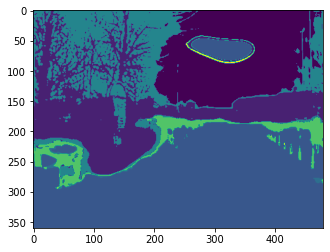

In [ ]:
from matplotlib import pyplot as plt
print(result.shape)

img = np.argmax(result[0,:,:,:], axis = 2)
plt.imshow(img)
plt.show()

(102, 360, 480, 12)


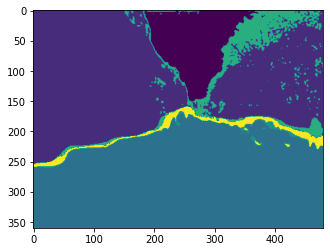

In [ ]:
from matplotlib import pyplot as plt
print(result.shape)

img = np.argmax(result[1,:,:,:], axis = 2)
plt.imshow(img)
plt.show()